# (7주차) 10월18일
> Pytorch CNN (MNIST 3,7)

- toc:true
- branch: master
- badges: true
- comments: true
- author: 최규빈

## 강의영상 

> https://youtube.com/playlist?list=PLQqh36zP38-ymnoeGZPPvaaB35JmhRiTi

## import 

In [56]:
import torch 
import torchvision
from fastai.vision.all import * 
import time

In [2]:
import graphviz
def gv(s): return graphviz.Source('digraph G{ rankdir="LR"'+s + '; }');

In [3]:
#hide
graphviz.set_jupyter_format('png')

'svg'

## data 

`-` download data 

In [228]:
path = untar_data(URLs.MNIST)

`-` training set 

In [229]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X = torch.concat([X0,X1])/255
y = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)

`-` test set 

In [230]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/1').ls()])
XX = torch.concat([X0,X1])/255
yy = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)

In [231]:
X.shape,XX.shape,y.shape,yy.shape

(torch.Size([12665, 1, 28, 28]),
 torch.Size([2115, 1, 28, 28]),
 torch.Size([12665, 1]),
 torch.Size([2115, 1]))

## CNN 예비학습

### 기존의 MLP 모형 

`-` 교재의 모형 

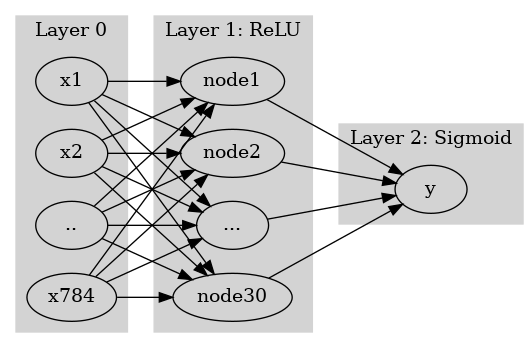

In [127]:
#collapse
gv('''
splines=line
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "x1"
    "x2"
    ".."
    "x784"
    label = "Layer 0"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "x1" -> "node1"
    "x2" -> "node1"
    ".." -> "node1"
    
    "x784" -> "node1"
    "x1" -> "node2"
    "x2" -> "node2"
    ".." -> "node2"
    "x784" -> "node2"
    
    "x1" -> "..."
    "x2" -> "..."
    ".." -> "..."
    "x784" -> "..."

    "x1" -> "node30"
    "x2" -> "node30"
    ".." -> "node30"
    "x784" -> "node30"


    label = "Layer 1: ReLU"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;
    "node1" -> "y"
    "node2" -> "y"
    "..." -> "y"
    "node30" -> "y"
    label = "Layer 2: Sigmoid"
}
''')

`-` 왜 28$\times$28 이미지를 784개의 벡터로 만든 다음에 모형을 돌려야 하는가? 

`-` 기존에 개발된 모형이 회귀분석 기반으로 되어있어서 결국 회귀분석 틀에 짜 맞추어서 이미지자료를 분석하는 느낌 

`-` observation의 차원은 $784$가 아니라 $1\times (28\times 28)$이 되어야 맞다. 

### 새로운 아키텍처의 제시

`-` 예전

$\underset{(n,784)}{\bf X} \overset{l_1}{\to} \underset{(n,32)}{\boldsymbol u^{(1)}} \overset{relu}{\to} \underset{(n,32)}{\boldsymbol v^{(1)}} \overset{l_1}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{sig}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$  

- $l_1$: 선형변환, feature를 뻥튀기하는 역할 
- $relu$: 뻥튀기된 feature에 비선형을 추가하여 표현력 극대화 
- $l_2$: 선형변환, 뻥튀기된 feature를 요약 하는 역할 (=데이터를 요약하는 역할) 

`-` 새로운 아키텍처 
- $conv$: feature를 뻥튀기하는 역할 (2d ver $l_1$ 느낌) 
- $relu$: 
- $pooling$: 데이터를 요약하는 역할 

### CONV 레이어 (선형변환의 2D 버전) 

`-` 우선 연산하는 방법을 살펴보자. (왜 이렇게 연산하는지는 일단 생각하지 말자)

**(예시1)**

In [128]:
torch.manual_seed(43052)
_conv = torch.nn.Conv2d(1,1,(2,2)) # 입력1, 출력1, 윈도우2 
_X = torch.arange(0,4).float().reshape(1,2,2) 

In [129]:
_X

tensor([[[0., 1.],
         [2., 3.]]])

In [130]:
_conv.weight, _conv.bias

(Parameter containing:
 tensor([[[[-0.1733, -0.4235],
           [ 0.1802,  0.4668]]]], requires_grad=True),
 Parameter containing:
 tensor([0.2037], requires_grad=True))

In [131]:
(0)*(-0.1733) + (1)*(-0.4235) + \
(2)*(0.1802) + (3)*(0.4668) + \
(0.2037) 

1.541

In [132]:
_conv(_X)

tensor([[[1.5410]]], grad_fn=<SqueezeBackward1>)

**(예시2) 잘하면 평균도 계산하겠다?**

In [133]:
_conv.weight.data, _conv.bias.data

(tensor([[[[-0.1733, -0.4235],
           [ 0.1802,  0.4668]]]]),
 tensor([0.2037]))

In [134]:
_conv.weight.data = torch.tensor([[[[0.25, 0.25],[0.25,0.25]]]])
_conv.bias.data = torch.tensor([0.0])

In [135]:
_conv(_X), (0+1+2+3)/4

(tensor([[[1.5000]]], grad_fn=<SqueezeBackward1>), 1.5)

**(예시3) 이동평균?**

In [136]:
_X = torch.arange(0,25).float().reshape(1,5,5)
_X

tensor([[[ 0.,  1.,  2.,  3.,  4.],
         [ 5.,  6.,  7.,  8.,  9.],
         [10., 11., 12., 13., 14.],
         [15., 16., 17., 18., 19.],
         [20., 21., 22., 23., 24.]]])

In [137]:
_conv(_X) 

tensor([[[ 3.,  4.,  5.,  6.],
         [ 8.,  9., 10., 11.],
         [13., 14., 15., 16.],
         [18., 19., 20., 21.]]], grad_fn=<SqueezeBackward1>)

**(예시4) window size가 증가한다면? (2d의 이동평균느낌)**

In [138]:
_conv = torch.nn.Conv2d(1,1,(3,3)) 

In [139]:
_conv.weight.data = torch.tensor([[[[ 1/9, 1/9, 1/9],[1/9, 1/9, 1/9],[1/9, 1/9, 1/9]]]])
_conv.bias.data = torch.tensor([0.0])

In [140]:
_X, _conv(_X)

(tensor([[[ 0.,  1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.,  9.],
          [10., 11., 12., 13., 14.],
          [15., 16., 17., 18., 19.],
          [20., 21., 22., 23., 24.]]]),
 tensor([[[ 6.0000,  7.0000,  8.0000],
          [11.0000, 12.0000, 13.0000],
          [16.0000, 17.0000, 18.0000]]], grad_fn=<SqueezeBackward1>))

In [141]:
(0+1+2+5+6+7+10+11+12)/9 

6.0

**(예시5) 피처뻥튀기**

In [142]:
_X = torch.tensor([1.0,1.0,1.0,1.0]).reshape(1,2,2) 
_X

tensor([[[1., 1.],
         [1., 1.]]])

In [143]:
_conv = torch.nn.Conv2d(1,8,(2,2)) 
_conv

Conv2d(1, 8, kernel_size=(2, 2), stride=(1, 1))

In [144]:
_conv(_X).shape

torch.Size([8, 1, 1])

결과 보고 짜맞추기: 예제1과 같은 연산을 8번 반복했을 것임 아마도 $\to$ 확인해보자 

In [145]:
_conv.weight.data.shape, _conv.bias.data.shape

(torch.Size([8, 1, 2, 2]), torch.Size([8]))

In [146]:
torch.sum(_conv.weight.data[0,...])+ _conv.bias.data[0], \
_conv(_X)[0]

(tensor(-0.3464), tensor([[-0.3464]], grad_fn=<SelectBackward0>))

In [147]:
torch.sum(_conv.weight.data[1,...])+ _conv.bias.data[1], \
_conv(_X)[1]

(tensor(0.2739), tensor([[0.2739]], grad_fn=<SelectBackward0>))

그러니까 이걸 했다는거지? 

In [148]:
torch.sum(_conv.weight.data,axis=(2,3)).reshape(-1) + _conv.bias.data

tensor([-0.3464,  0.2739,  0.1069,  0.6105,  0.0432,  0.8390,  0.2353,  0.2345])

In [149]:
_conv(_X).reshape(-1)

tensor([-0.3464,  0.2739,  0.1069,  0.6105,  0.0432,  0.8390,  0.2353,  0.2345],
       grad_fn=<ReshapeAliasBackward0>)

***(잔소리) axis 사용 익숙하지 않으면 아래 꼭 들으세요..***

- https://guebin.github.io/IP2022/2022/04/11/(6주차)-4월11일.html , numpy공부 4단계: 축

### ReLU (2d)

In [150]:
_X = torch.randn(25).reshape(5,5) 
_X 

tensor([[ 0.2656,  0.0780,  3.0465,  1.0151, -2.3908],
        [ 0.4749,  1.6519,  1.5454,  1.0376,  0.9291],
        [-0.7858,  0.4190,  2.6057, -0.4022,  0.2092],
        [ 0.9594,  0.6408, -0.0411, -1.0720, -2.0659],
        [-0.0996,  1.1351,  0.9758,  0.4952, -0.5475]])

In [151]:
a1=torch.nn.ReLU()

In [152]:
a1(_X)

tensor([[0.2656, 0.0780, 3.0465, 1.0151, 0.0000],
        [0.4749, 1.6519, 1.5454, 1.0376, 0.9291],
        [0.0000, 0.4190, 2.6057, 0.0000, 0.2092],
        [0.9594, 0.6408, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.1351, 0.9758, 0.4952, 0.0000]])

### Maxpooling 레이어

In [153]:
_maxpooling = torch.nn.MaxPool2d((2,2))
_X = torch.arange(0,16).float().reshape(1,4,4)

In [154]:
_X,_maxpooling(_X)

(tensor([[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]),
 tensor([[[ 5.,  7.],
          [13., 15.]]]))

In [155]:
_X = torch.arange(0,25).float().reshape(1,5,5)
_X,_maxpooling(_X) 

(tensor([[[ 0.,  1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.,  9.],
          [10., 11., 12., 13., 14.],
          [15., 16., 17., 18., 19.],
          [20., 21., 22., 23., 24.]]]),
 tensor([[[ 6.,  8.],
          [16., 18.]]]))

In [156]:
_X = torch.arange(0,36).float().reshape(1,6,6)
_X,_maxpooling(_X) 

(tensor([[[ 0.,  1.,  2.,  3.,  4.,  5.],
          [ 6.,  7.,  8.,  9., 10., 11.],
          [12., 13., 14., 15., 16., 17.],
          [18., 19., 20., 21., 22., 23.],
          [24., 25., 26., 27., 28., 29.],
          [30., 31., 32., 33., 34., 35.]]]),
 tensor([[[ 7.,  9., 11.],
          [19., 21., 23.],
          [31., 33., 35.]]]))

## CNN 구현 (CPU)

In [157]:
X.shape,XX.shape, y.shape, yy.shape

(torch.Size([12665, 1, 28, 28]),
 torch.Size([2115, 1, 28, 28]),
 torch.Size([12665, 1]),
 torch.Size([2115, 1]))

### (1) Conv2d

In [158]:
c1=torch.nn.Conv2d(1,16,(5,5)) # 입력채널=1 (흑백이므로), 출력채널=16, 윈도우크기5 

In [159]:
print(X.shape)
print(c1(X).shape)

torch.Size([12665, 1, 28, 28])
torch.Size([12665, 16, 24, 24])


### (2) ReLU

In [160]:
a1 =torch.nn.ReLU()  

In [161]:
print(X.shape)
print(c1(X).shape)
print(a1(c1(X)).shape)

torch.Size([12665, 1, 28, 28])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 24, 24])


### (3) MaxPool2D

In [162]:
m1 = torch.nn.MaxPool2d((2,2)) 

In [163]:
print(X.shape)
print(c1(X).shape)
print(m1(a1(c1(X))).shape)

torch.Size([12665, 1, 28, 28])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 12, 12])


### (4) 적당히 마무리하고 시그모이드 태우자 

`-` 현재상황 

In [164]:
a1(m1(c1(X))).shape

torch.Size([12665, 16, 12, 12])

`-` 펼치자 

(방법1)

In [165]:
a1(m1(c1(X))).reshape(12665,-1).shape

torch.Size([12665, 2304])

(방법2)

In [166]:
flttn = torch.nn.Flatten() 

In [167]:
flttn(a1(m1(c1(X)))).shape

torch.Size([12665, 2304])

`-` 2304의 디멘젼을 1로 만들자. (그래야 시그모이드에 태우니까) 

In [168]:
l1=torch.nn.Linear(in_features=2304,out_features=1) 

In [169]:
l1(flttn(a1(m1(c1(X))))).shape

torch.Size([12665, 1])

`-` 시그모이드를 걸자. 

In [170]:
a2=torch.nn.Sigmoid() 
a2(l1(flttn(a1(m1(c1(X)))))).shape

torch.Size([12665, 1])

### networks 설계 

In [171]:
net = nn.Sequential(
    c1, # 2d part: 컨볼루션(선형)
    m1, # 2d part: 맥스풀링(비선형) -- 효과? 이미지를 계층적으로 파악할 수 있게함 
    a1, # 2d part: 렐루(비선형) 
    flttn, # 펼치자
    l1, # 1d part: 선형변환
    a2) # 1d part: 시그모이드 

`-` 손실함수와 옵티마이저 정의 

In [172]:
loss_fn=torch.nn.BCELoss()
optimizr= torch.optim.Adam(net.parameters())

`-` step1~4

In [173]:
t1= time.time()
for epoc in range(100): 
    ## 1 
    yhat=net(X)
    ## 2 
    loss=loss_fn(yhat,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2-t1

39.42988872528076

- 컴퓨터야 많이 힘들어?

Text(0.5, 1.0, 'Traning Set')

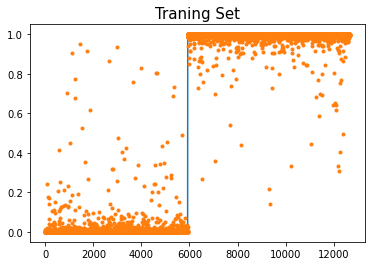

In [174]:
plt.plot(y)
plt.plot(net(X).data,'.')
plt.title('Traning Set',size=15)

Text(0.5, 1.0, 'Test Set')

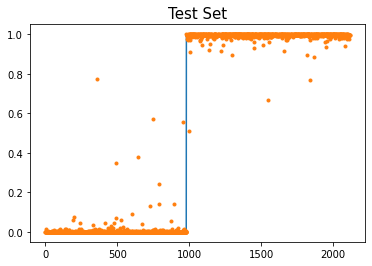

In [175]:
plt.plot(yy)
plt.plot(net(XX).data,'.')
plt.title('Test Set',size=15)

## CNN 구현 (GPU)

### 1. dls

In [375]:
ds1=torch.utils.data.TensorDataset(X,y)
ds2=torch.utils.data.TensorDataset(XX,yy)

In [376]:
len(X)/10

1266.5

In [377]:
len(XX)

2115

In [378]:
dl1 = torch.utils.data.DataLoader(ds1,batch_size=1266) 
dl2 = torch.utils.data.DataLoader(ds2,batch_size=2115) 

In [379]:
dls = DataLoaders(dl1,dl2) # 이거 fastai 지원함수입니다

### 2. lrnr 생성: 아키텍처, 손실함수, 옵티마이저 

In [380]:
net=torch.nn.Sequential(
    torch.nn.Conv2d(1,16,5), 
    torch.nn.MaxPool2d(2), 
    torch.nn.ReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(2304,1),
    torch.nn.Sigmoid()
)

In [381]:
loss_fn=torch.nn.BCELoss()
#optimizer= torch.optim.Adam(net.parameters())

In [382]:
lrnr1 = Learner(dls,net,loss_fn) 

### 3. 학습

In [383]:
lrnr1.fit(10)

epoch,train_loss,valid_loss,time
0,0.927311,0.648322,00:00
1,0.718625,0.469040,00:00
2,0.588866,0.330591,00:00
3,0.483140,0.195508,00:00
4,0.386450,0.102665,00:00
5,0.304847,0.056062,00:00
6,0.240853,0.034480,00:00
7,0.191728,0.023759,00:00
8,0.153885,0.017779,00:00
9,0.124454,0.014066,00:00


### 4. 예측 및 시각화 

`-` 결과를 시각화하면 아래와 같다. 

Text(0.5, 1.0, 'Training Set')

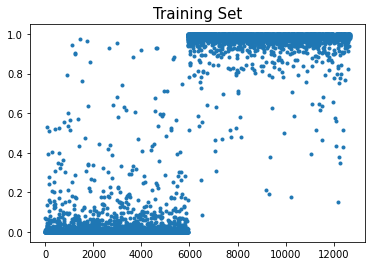

In [384]:
plt.plot(net(X.to("cuda:0")).to("cpu").data,'.')
plt.title("Training Set",size=15)

Text(0.5, 1.0, 'Test Set')

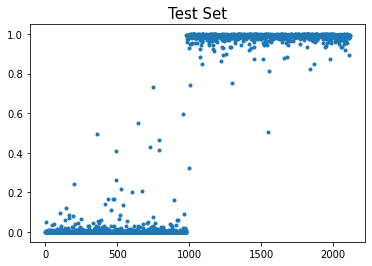

In [385]:
plt.plot(net(XX.to("cuda:0")).to("cpu").data,'.')
plt.title("Test Set",size=15)

`-` 빠르고 적합결과도 좋음 

### Lrnr 오브젝트

In [192]:
lrnr1.model ## ㅎㅎ 우리가 짠거다

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=2304, out_features=1, bias=True)
  (5): Sigmoid()
)

In [193]:
net

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=2304, out_features=1, bias=True)
  (5): Sigmoid()
)

In [194]:
id(net), id(lrnr1.model)

(139936231681232, 139936231681232)

### BCEWithLogitsLoss

`-` BCEWithLogitsLoss = Sigmoid + BCELoss
- 왜 써요? 수치적으로 더 안정 

`-` 사용방법

(1) dls 만들기 

In [386]:
ds1=torch.utils.data.TensorDataset(X,y)
ds2=torch.utils.data.TensorDataset(XX,yy)

In [387]:
len(X)/10

1266.5

In [388]:
len(XX)

2115

In [389]:
dl1 = torch.utils.data.DataLoader(ds1,batch_size=1266) 
dl2 = torch.utils.data.DataLoader(ds2,batch_size=2115) 

In [390]:
dls = DataLoaders(dl1,dl2) # 이거 fastai 지원함수입니다

(2) lrnr생성 

In [391]:
net=torch.nn.Sequential(
    torch.nn.Conv2d(1,16,5), 
    torch.nn.MaxPool2d(2), 
    torch.nn.ReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(2304,1),
    #torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCEWithLogitsLoss()

In [392]:
lrnr2 = Learner(dls,net,loss_fn) # dls는 아까 만든것 재활용

(3) 학습

In [393]:
lrnr2.fit(10)

epoch,train_loss,valid_loss,time
0,0.915525,0.618521,00:00
1,0.677863,0.408427,00:00
2,0.536873,0.254241,00:00
3,0.425524,0.131684,00:00
4,0.331317,0.070062,00:00
5,0.258546,0.042935,00:00
6,0.204148,0.030023,00:00
7,0.163170,0.022849,00:00
8,0.131817,0.018366,00:00
9,0.107467,0.015309,00:00


(4) 예측 및 시각화

In [411]:
a2

Sigmoid()

In [412]:
net.to("cpu")

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=2304, out_features=1, bias=True)
)

Text(0.5, 0.98, 'Training Set')

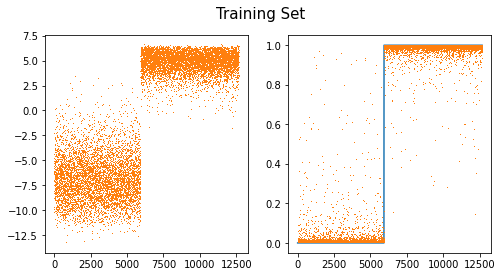

In [414]:
fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(net(X).data,',',color="C1")
ax[1].plot(y)
ax[1].plot(a2(net(X)).data,',')
fig.suptitle("Training Set",size=15)

Text(0.5, 0.98, 'Test Set')

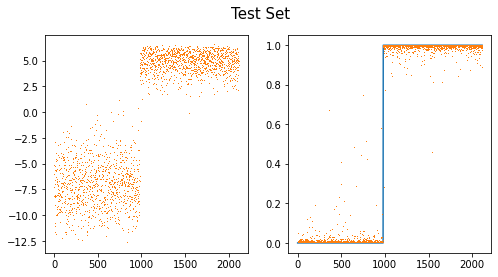

In [415]:
fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(net(XX).data,',',color="C1")
ax[1].plot(yy)
ax[1].plot(a2(net(XX)).data,',')
fig.suptitle("Test Set",size=15)

### CrossEntropyLoss

`-` CrossEntropyLoss = Softmax + CrossEntropyLoss // 따라서 엄밀하게는 CEWithSoftmaxLoss 정도로 써야 맞음 
- 왜 써요? 다차원으로 확장이 용이

`-` 사용방법

(1) dls 만들기 

In [510]:
ds1=torch.utils.data.TensorDataset(X,y.reshape(-1).to(torch.long))
ds2=torch.utils.data.TensorDataset(XX,yy.reshape(-1).to(torch.long))

In [514]:
len(X)/10

1266.5

In [515]:
len(XX)

2115

In [516]:
dl1 = torch.utils.data.DataLoader(ds1,batch_size=1266) 
dl2 = torch.utils.data.DataLoader(ds2,batch_size=2115) 

In [517]:
dls = DataLoaders(dl1,dl2) # 이거 fastai 지원함수입니다

(2) lrnr생성 

In [518]:
net=torch.nn.Sequential(
    torch.nn.Conv2d(1,16,5), 
    torch.nn.MaxPool2d(2), 
    torch.nn.ReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(2304,2)
    #torch.nn.Sigmoid()
)
loss_fn = torch.nn.CrossEntropyLoss()

In [519]:
lrnr2 = Learner(dls,net,loss_fn) 

(3) 학습

In [520]:
lrnr2.fit(10)

epoch,train_loss,valid_loss,time
0,1.135065,0.561457,00:00
1,0.660589,0.286233,00:00
2,0.484370,0.120203,00:00
3,0.355279,0.060064,00:00
4,0.266070,0.037402,00:00
5,0.203845,0.026049,00:00
6,0.159403,0.020099,00:00
7,0.126771,0.016359,00:00
8,0.102148,0.013762,00:00
9,0.083171,0.011860,00:00


(4) 예측 및 시각화

In [530]:
sftmax = torch.nn.Softmax(dim=1)

In [532]:
torch.nn.Softmax?

Init signature: torch.nn.Softmax(dim: Union[int, NoneType] = None) -> None
Docstring:     
Applies the Softmax function to an n-dimensional input Tensor
rescaling them so that the elements of the n-dimensional output Tensor
lie in the range [0,1] and sum to 1.

Softmax is defined as:

.. math::
    \text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}

When the input Tensor is a sparse tensor then the unspecifed
values are treated as ``-inf``.

Shape:
    - Input: :math:`(*)` where `*` means, any number of additional
      dimensions
    - Output: :math:`(*)`, same shape as the input

Returns:
    a Tensor of the same dimension and shape as the input with
    values in the range [0, 1]

Args:
    dim (int): A dimension along which Softmax will be computed (so every slice
        along dim will sum to 1).

.. note::
    This module doesn't work directly with NLLLoss,
    which expects the Log to be computed between the Softmax and itself.
    Use `LogSoftmax` instead (it's faster a

In [527]:
net.to("cpu")

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=2304, out_features=2, bias=True)
)

In [535]:
sftmax(net(X))[:,1]

tensor([1.9528e-04, 1.0992e-03, 2.6890e-03,  ..., 9.9659e-01, 9.9456e-01,
        9.8520e-01], grad_fn=<SelectBackward0>)

Text(0.5, 0.98, 'Training Set')

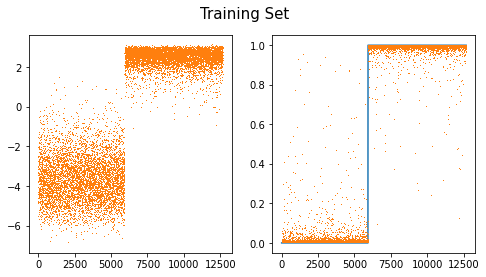

In [537]:
fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(net(X)[:,1].data,',',color="C1")
ax[1].plot(y)
ax[1].plot(sftmax(net(X))[:,1].data,',')
fig.suptitle("Training Set",size=15)

Text(0.5, 0.98, 'Test Set')

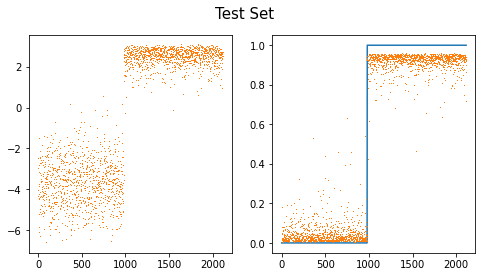

In [538]:
fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(net(XX)[:,1].data,',',color="C1")
ax[1].plot(yy)
ax[1].plot(a2(net(XX))[:,1].data,',')
fig.suptitle("Test Set",size=15)

## Appendix 

### `A1`. 소프트맥스 vs 시그모이드 

(예비학습)

아래는 사실상 같은 네트워크라고 봐도 무방하다. 

(1) $\hat{y}_i = \hat{\beta}_0 +\hat{\beta}_1x_i$

(2) $\hat{y}_i = \hat{\beta}_0 + (\hat{\alpha}_1+\hat{\beta}_1) x_i$

(3) $\hat{y}_i = \hat{\alpha}_0+\hat{\beta}_0 +\hat{\beta}_1x_i$

(4) $\hat{y}_i = \hat{\alpha}_0+\hat{\beta}_0 +(\hat{\alpha}_1+\hat{\beta}_1)x_i$

네트워크의 표현력은 (1)과 동일함. 즉 (2)-(4)는 사실상 (1)과 동일한 아키텍처를 기술한 것임. 그런데 학습할 파라메터만 많은 꼴. 

`-` 시그모이드 

- y의 형태: 고양이=0, 개=1 

- 마지막 활성화함수: $u \to \frac{e^u}{1+e^u}$ 이때 $u$는 시그모이드층의 인풋 (=마지막 리니어층의 아웃풋)

- $u$의 값이 클수록 dog

`-` 소프트맥스 

- $y$의 형태: 고양이=[1,0], 개=[0,1] 

- 마지막 활성화함수: $(u_1,u_2) \to \big(\frac{e^{u_1}}{e^{u_1}+e^{u_2}},\frac{e^{u_2}}{e^{u_1}+e^{u_2}} \big)$, 이때 $(u_1,u_2)$는 소프트맥스의 인풋 (=마지막 리니어층의 아웃풋)

- $u_1$의 값이 클수록 cat, $u_2$의 값이 클수록 dog 

`-` 참고로 $\big(\frac{e^{u_1}}{e^{u_1}+e^{u_2}},\frac{e^{u_2}}{e^{u_1}+e^{u_2}} \big)$에서 분자분모에 각각 $e^{-u_1}$을 곱하면

$$\big(\frac{1}{1+e^{u_2-u_1}},\frac{e^{u_2-u_1}}{1+e^{u_2-u_1}} \big)$$

그리고 $u_2-u_1=u$라고 생각하면 

$$\big(\frac{1}{1+e^{u}},\frac{e^{u}}{1+e^{u}} \big)$$

이므로, 강아지라고 생각할 확률은 $\frac{e^u}{1+e^u}$, 고양이라고 생각할 확률은 $1-\frac{e^u}{1+e^u}$이 되므로 마지막 활성화 함수를 $u \to \frac{e^u}{1+e^u}$ 시그모이드와 같아진다.

`-`  결국 아래의 두 네트워크는 사실상 같은 네트워크임 (두 네트워크는 사실상 동일한 아키텍처를 기술하는 것임) 

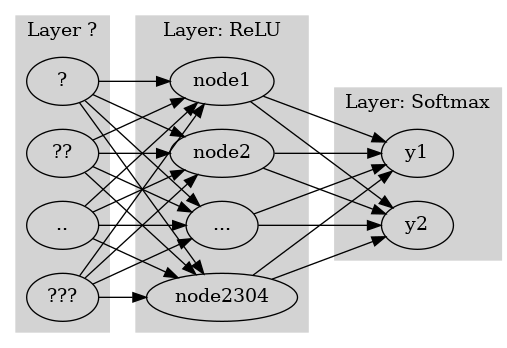

In [555]:
#collapse
gv('''
splines=line
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "?"
    "??"
    ".."
    "???"
    label = "Layer ?"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "?" -> "node1"
    "??" -> "node1"
    ".." -> "node1"
    "???" -> "node1"
    
    "?" -> "node2"
    "??" -> "node2"
    ".." -> "node2"
    "???" -> "node2"
    
    "?" -> "..."
    "??" -> "..."
    ".." -> "..."
    "???" -> "..."
    
    "?" -> "node2304"
    "??" -> "node2304"
    ".." -> "node2304"
    "???" -> "node2304"

    label = "Layer: ReLU"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;
    "node1" -> "y1"
    "node2" -> "y1"
    "..." -> "y1"
    "node2304" -> "y1"
    
    "node1" -> "y2"
    "node2" -> "y2"
    "..." -> "y2"
    "node2304" -> "y2"    
    label = "Layer: Softmax"
}
''')

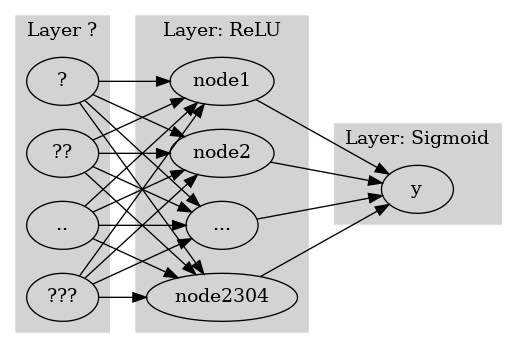

In [556]:
#collapse
gv('''
splines=line
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "?"
    "??"
    ".."
    "???"
    label = "Layer ?"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "?" -> "node1"
    "??" -> "node1"
    ".." -> "node1"
    "???" -> "node1"
    
    "?" -> "node2"
    "??" -> "node2"
    ".." -> "node2"
    "???" -> "node2"
    
    "?" -> "..."
    "??" -> "..."
    ".." -> "..."
    "???" -> "..."
    
    "?" -> "node2304"
    "??" -> "node2304"
    ".." -> "node2304"
    "???" -> "node2304"

    label = "Layer: ReLU"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;
    "node1" -> "y"
    "node2" -> "y"
    "..." -> "y"
    "node2304" -> "y"
    label = "Layer: Sigmoid"
}
''')

`-` 엄밀히 따지면 이는 파라메터의 낭비임. 하지만 Softmax를 생각하는 것은 다차원 카테고리로 확장이 용이하기 때문임. 만약에 개,고양이,사자를 구분해야하는 문제가 나온다면 sigmoid는 표현이 애매해지지만 softmax는 가능함.

`-` 결론 
1. 소프트맥스는 시그모이드의 확장이다. 
2. 클래스의 수가 2개일 경우에는 (Sigmoid, BCEloss) 조합을 사용해야 하고 클래스의 수가 2개보다 클 경우에는 (Softmax, CrossEntropyLoss) 를 사용해야 한다. 


`-` 그런데 사실.. 
1. 클래스의 수가 2개일 경우일때 (Softmax, CrossEntropyLoss)를 사용해도 그렇게 큰일나는것은 아니다. (흑백이미지를 칼라잉크로 출력하는 느낌) 
2. 실제로 클래스의 수가 2개일때 (Softmax, CrossEntropyLoss)를 많이 사용 (왜? transfer learning)


***참고***

|$y$|분포가정|마지막층의 활성화함수|손실함수(파이토치)|
|:--:|:--:|:--:|:--:|
|3.45, 4.43, ... (연속형) |정규분포|Linear|MSEloss|
|0 or 1|이항분포(베르누이)|Sigmoid| BCEloss|
|[0,0,1], [0,1,0], [1,0,0]| 다항분포|Softmax| CrossEntropyLoss|